In [1]:

pip install pandas numpy scikit-learn matplotlib seaborn flask


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/cmc/cmc.data"
columns = ["Wife's age", "Wife's education", "Husband's education", "Number of children", "Wife's religion", 
           "Wife now working?", "Husband's occupation", "Standard-of-living index", "Media exposure", 
           "Contraceptive method used"]
data = pd.read_csv(url, names=columns)


In [4]:
# Separate features and target
X = data.drop("Contraceptive method used", axis=1)
y = data["Contraceptive method used"]

# Define preprocessing steps
numeric_features = ["Wife's age", "Number of children"]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ["Wife's education", "Husband's education", "Wife's religion", 
                        "Wife now working?", "Husband's occupation", 
                        "Standard-of-living index", "Media exposure"]
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Create preprocessing and modeling pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
# Train the model
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ["Wife's age",
                                                   'Number of children']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ["Wife's education",
                                                   "Husband's education",
                                                   "Wife's religion",
                                                   'Wife now working?',
                                                   "Husband's occupation",
                                                   'Standard-of-living index',
                                                   'Media exposure'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

Accuracy: 0.5423728813559322

Classification Report:
               precision    recall  f1-score   support

           1       0.63      0.68      0.65       130
           2       0.46      0.35      0.40        71
           3       0.47      0.50      0.48        94

    accuracy                           0.54       295
   macro avg       0.52      0.51      0.51       295
weighted avg       0.54      0.54      0.54       295


Confusion Matrix:
 [[88 14 28]
 [20 25 26]
 [32 15 47]]


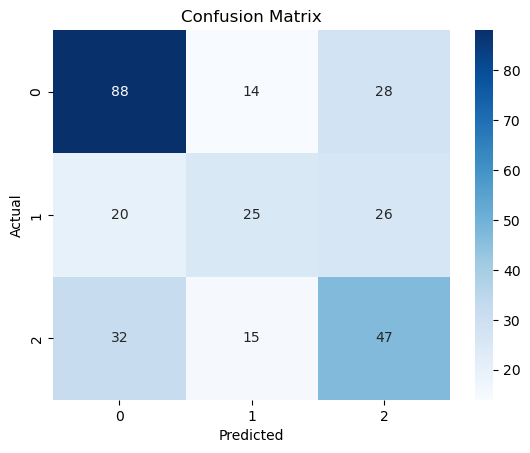

In [6]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Visualize confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [8]:
import pickle

with open('model.pkl', 'wb') as f:
    pickle.dump(model, f)


In [14]:
%%writefile app.py

from flask import Flask, request, jsonify
import pickle
import pandas as pd

app = Flask(__name__)

# Load the trained model
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json()
    df = pd.DataFrame([data])
    prediction = model.predict(df)
    return jsonify({'prediction': int(prediction[0])})

if __name__ == '__main__':
    app.run(debug=True)



Overwriting app.py


In [17]:
import requests
import json

url = 'http://127.0.0.1:5000/predict'
data = {
    "Wife's age": 30,
    "Wife's education": 2,
    "Husband's education": 3,
    "Number of children": 2,
    "Wife's religion": 1,
    "Wife now working?": 0,
    "Husband's occupation": 2,
    "Standard-of-living index": 3,
    "Media exposure": 1
}
headers = {'Content-Type': 'application/json'}

response = requests.post(url, headers=headers, data=json.dumps(data))
print(response.json())


{'prediction': 1}
